### Import libs

In [1]:
import pandas as pd
from __future__ import print_function
import os
import warnings

from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight


import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adamax

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout,GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Embedding

from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

### Class Gadget Vector

In [ ]:
import re
import sys

import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
import numpy

# Sets for operators
operators3 = {'<<=', '>>='}
operators2 = {
    '->', '++', '--',
    '!~', '<<', '>>', '<=', '>=',
    '==', '!=', '&&', '||', '+=',
    '-=', '*=', '/=', '%=', '&=', '^=', '|='
    }
operators1 = {
    '(', ')', '[', ']', '.',
    '+', '-', '*', '&', '/',
    '%', '<', '>', '^', '|',
    '=', ',', '?', ':' , ';',
    '{', '}'
    }

"""
Functionality to train Word2Vec model and vectorize gadgets
Buffers list of tokenized gadgets in memory
Trains Word2Vec model using list of tokenized gadgets
Uses trained model embeddings to create 2D gadget vectors
"""
class GadgetVectorizer:
    def __init__(self, vector_length):
        self.gadgets = []
        self.vector_length = vector_length
        self.forward_slices = 0
        self.backward_slices = 0

    """
    Takes a line of C++ code (string) as input
    Tokenizes C++ code (breaks down into identifier, variables, keywords, operators)
    Returns a list of tokens, preserving order in which they appear
    """
    @staticmethod
    def tokenize(line):
        tmp, w = [], []
        i = 0
        while i < len(line):
            # Ignore spaces and combine previously collected chars to form words
            if line[i] == ' ':
                tmp.append(''.join(w))
                tmp.append(line[i])
                w = []
                i += 1
            # Check operators and append to final list
            elif line[i:i+3] in operators3:
                tmp.append(''.join(w))
                tmp.append(line[i:i+3])
                w = []
                i += 3
            elif line[i:i+2] in operators2:
                tmp.append(''.join(w))
                tmp.append(line[i:i+2])
                w = []
                i += 2
            elif line[i] in operators1:
                tmp.append(''.join(w))
                tmp.append(line[i])
                w = []
                i += 1
            # Character appended to word list
            else:
                w.append(line[i])
                i += 1
        # Filter out irrelevant strings
        res = list(filter(lambda c: c != '', tmp))
        return list(filter(lambda c: c != ' ', res))

    """
    Tokenize entire gadget
    Tokenize each line and concatenate to one long list
    """
    @staticmethod
    def tokenize_gadget(gadget):
        tokenized = []
        function_regex = re.compile('FUN(\d)+')
        backwards_slice = False
        for line in gadget:
            tokens = GadgetVectorizer.tokenize(line)
            tokenized += tokens
            if len(list(filter(function_regex.match, tokens))) > 0:
                backwards_slice = True
            else:
                backwards_slice = False
        return tokenized, backwards_slice

    """
    Add input gadget to model
    Tokenize gadget and buffer it to list
    """
    def add_gadget(self, gadget):
        tokenized_gadget, backwards_slice = GadgetVectorizer.tokenize_gadget(gadget)
        self.gadgets.append(tokenized_gadget)
        if backwards_slice:
            self.backward_slices += 1
        else:
            self.forward_slices += 1

    """
    Uses Word2Vec to create a vector for each gadget
    Gets a vector for the gadget by combining token embeddings
    Number of tokens used is min of number_of_tokens and 50
    """
    def vectorize(self, gadget):
        tokenized_gadget, backwards_slice = GadgetVectorizer.tokenize_gadget(gadget)
        vectors = numpy.zeros(shape=(50, self.vector_length))
        if backwards_slice:
            for i in range(min(len(tokenized_gadget), 50)):
                vectors[50 - 1 - i] = self.embeddings[tokenized_gadget[len(tokenized_gadget) - 1 - i]]
        else:
            for i in range(min(len(tokenized_gadget), 50)):
                vectors[i] = self.embeddings[tokenized_gadget[i]]
        return vectors

    """
    Done adding gadgets, now train Word2Vec model
    Only keep list of embeddings, delete model and list of gadgets
    """
    def train_model(self):
        # Set min_count to 1 to prevent out-of-vocabulary errors
        model = Word2Vec(self.gadgets, min_count=1, vector_size=self.vector_length, sg=1)
        self.embeddings = model.wv
        del model
        del self.gadgets

In [ ]:
# keywords up to C11 and C++17; immutable set
keywords = frozenset({'__asm', '__builtin', '__cdecl', '__declspec', '__except', '__export', '__far16', '__far32',
                      '__fastcall', '__finally', '__import', '__inline', '__int16', '__int32', '__int64', '__int8',
                      '__leave', '__optlink', '__packed', '__pascal', '__stdcall', '__system', '__thread', '__try',
                      '__unaligned', '_asm', '_Builtin', '_Cdecl', '_declspec', '_except', '_Export', '_Far16',
                      '_Far32', '_Fastcall', '_finally', '_Import', '_inline', '_int16', '_int32', '_int64',
                      '_int8', '_leave', '_Optlink', '_Packed', '_Pascal', '_stdcall', '_System', '_try', 'alignas',
                      'alignof', 'and', 'and_eq', 'asm', 'auto', 'bitand', 'bitor', 'bool', 'break', 'case',
                      'catch', 'char', 'char16_t', 'char32_t', 'class', 'compl', 'const', 'const_cast', 'constexpr',
                      'continue', 'decltype', 'default', 'delete', 'do', 'double', 'dynamic_cast', 'else', 'enum',
                      'explicit', 'export', 'extern', 'false', 'final', 'float', 'for', 'friend', 'goto', 'if',
                      'inline', 'int', 'long', 'mutable', 'namespace', 'new', 'noexcept', 'not', 'not_eq', 'nullptr',
                      'operator', 'or', 'or_eq', 'override', 'private', 'protected', 'public', 'register',
                      'reinterpret_cast', 'return', 'short', 'signed', 'sizeof', 'static', 'static_assert',
                      'static_cast', 'struct', 'switch', 'template', 'this', 'thread_local', 'throw', 'true', 'try',
                      'typedef', 'typeid', 'typename', 'union', 'unsigned', 'using', 'virtual', 'void', 'volatile',
                      'wchar_t', 'while', 'xor', 'xor_eq', 'NULL'})
# holds known non-user-defined functions; immutable set
main_set = frozenset({'main'})
# arguments in main function; immutable set
main_args = frozenset({'argc', 'argv'})

# input is a list of string lines
def clean_gadget(gadget):
    # dictionary; map function name to symbol name + number
    fun_symbols = {}
    # dictionary; map variable name to symbol name + number
    var_symbols = {}

    fun_count = 1
    var_count = 1

    # regular expression to catch multi-line comment
    rx_comment = re.compile('\*/\s*$')
    # regular expression to find function name candidates
    rx_fun = re.compile(r'\b([_A-Za-z]\w*)\b(?=\s*\()')
    # regular expression to find variable name candidates
    #rx_var = re.compile(r'\b([_A-Za-z]\w*)\b(?!\s*\()')
    rx_var = re.compile(r'\b([_A-Za-z]\w*)\b(?:(?=\s*\w+\()|(?!\s*\w+))(?!\s*\()')

    # final cleaned gadget output to return to interface
    cleaned_gadget = []

    for line in gadget:
        # process if not the header line and not a multi-line commented line
        if rx_comment.search(line) is None:
            # remove all string literals (keep the quotes)
            nostrlit_line = re.sub(r'".*?"', '""', line)
            # remove all character literals
            nocharlit_line = re.sub(r"'.*?'", "''", nostrlit_line)
            # replace any non-ASCII characters with empty string
            ascii_line = re.sub(r'[^\x00-\x7f]', r'', nocharlit_line)

            # return, in order, all regex matches at string list; preserves order for semantics
            user_fun = rx_fun.findall(ascii_line)
            user_var = rx_var.findall(ascii_line)

            # Could easily make a "clean gadget" type class to prevent duplicate functionality
            # of creating/comparing symbol names for functions and variables in much the same way.
            # The comparison frozenset, symbol dictionaries, and counters would be class scope.
            # So would only need to pass a string list and a string literal for symbol names to
            # another function.
            for fun_name in user_fun:
                if len({fun_name}.difference(main_set)) != 0 and len({fun_name}.difference(keywords)) != 0:
                    # DEBUG
                    #print('comparing ' + str(fun_name + ' to ' + str(main_set)))
                    #print(fun_name + ' diff len from main is ' + str(len({fun_name}.difference(main_set))))
                    #print('comparing ' + str(fun_name + ' to ' + str(keywords)))
                    #print(fun_name + ' diff len from keywords is ' + str(len({fun_name}.difference(keywords))))
                    ###
                    # check to see if function name already in dictionary
                    if fun_name not in fun_symbols.keys():
                        fun_symbols[fun_name] = 'FUN' + str(fun_count)
                        fun_count += 1
                    # ensure that only function name gets replaced (no variable name with same
                    # identifier); uses positive lookforward
                    ascii_line = re.sub(r'\b(' + fun_name + r')\b(?=\s*\()', fun_symbols[fun_name], ascii_line)

            for var_name in user_var:
                # next line is the nuanced difference between fun_name and var_name
                if len({var_name}.difference(keywords)) != 0 and len({var_name}.difference(main_args)) != 0:
                    # DEBUG
                    #print('comparing ' + str(var_name + ' to ' + str(keywords)))
                    #print(var_name + ' diff len from keywords is ' + str(len({var_name}.difference(keywords))))
                    #print('comparing ' + str(var_name + ' to ' + str(main_args)))
                    #print(var_name + ' diff len from main args is ' + str(len({var_name}.difference(main_args))))
                    ###
                    # check to see if variable name already in dictionary
                    if var_name not in var_symbols.keys():
                        var_symbols[var_name] = 'VAR' + str(var_count)
                        var_count += 1
                    # ensure that only variable name gets replaced (no function name with same
                    # identifier); uses negative lookforward
                    ascii_line = re.sub(r'\b(' + var_name + r')\b(?:(?=\s*\w+\()|(?!\s*\w+))(?!\s*\()', \
                                        var_symbols[var_name], ascii_line)

            cleaned_gadget.append(ascii_line)
    # return the list of cleaned lines
    return cleaned_gadget

### Parser

In [ ]:
"""
Parses gadget file to find individual gadgets
Yields each gadget as list of strings, where each element is code line
Has to ignore first line of each gadget, which starts as integer+space
At the end of each code gadget is binary value
    This indicates whether or not there is vulnerability in that gadget
"""
def parse_file(filename):
    with open(filename, "r", encoding="utf8") as file:
        gadget = []
        gadget_val = 0
        for line in file:
            stripped = line.strip()
            if not stripped:
                continue
            if "-" * 30 in line and gadget: # 33/30
                yield clean_gadget(gadget), gadget_val
                gadget = []
            elif stripped.split()[0].isdigit():
                if gadget:
                    # Code line could start with number (somehow)
                    if stripped.isdigit():
                        gadget_val = int(stripped)
                    else:
                        gadget.append(stripped)
            else:
                gadget.append(stripped)

### Test code gadget

In [ ]:
filename = '/content/mvd.txt'
print(parse_file(filename))
file = parse_file(filename)

<generator object parse_file at 0x795aa12fe420>


### Get gadget vector

In [ ]:
"""
Uses gadget file parser to get gadgets and vulnerability indicators
Assuming all gadgets can fit in memory, build list of gadget dictionaries
    Dictionary contains gadgets and vulnerability indicator
    Add each gadget to GadgetVectorizer
Train GadgetVectorizer model, prepare for vectorization
Loop again through list of gadgets
    Vectorize each gadget and put vector into new list
Convert list of dictionaries to dataframe when all gadgets are processed
"""
def get_vectors_df(filename , vector_length=100):
    gadgets = []
    count = 0
    vectorizer = GadgetVectorizer(vector_length)
    for gadget, val in parse_file(filename):
        count += 1
        print("Collecting gadgets...", count, end="\r")
        vectorizer.add_gadget(gadget)
        row = {"gadget" : gadget, "val" : val}
        gadgets.append(row)
    print('Found {} forward slices and {} backward slices'
          .format(vectorizer.forward_slices, vectorizer.backward_slices))
    print()
    print("Training model...", end="\r")
    vectorizer.train_model()
    print()
    vectors = []
    count = 0
    for gadget in gadgets:
        count += 1
        print("Processing gadgets...", count, end="\r")
        vector = vectorizer.vectorize(gadget["gadget"])
        row = {"vector" : vector, "val" : gadget["val"]}
        vectors.append(row)
    print()
    df = pd.DataFrame(vectors)
    return df

### Get Code Attention

In [ ]:
def save_to_file(file_path, code_attention):
    output_folder = os.path.dirname(file_path)
    output_filename = os.path.splitext(os.path.basename(file_path))[
        0].replace('_normalized', '') + "_attention.txt"
    output_path = os.path.join(output_folder, output_filename)

    with open(output_path, 'w', encoding='utf-8') as output_file:
        for statement in code_attention:
            output_file.write(statement + '\n')


def extract_values(line):
    values = []
    R = {
        'definition_statement': ['auto', 'bool', 'char', 'char16_t', 'char32_t', 'double', 'float', 'int', 'long', 'short', 'signed', 'unsigned', 'void', 'wchar_t'],
        'control_statement': ['if', 'while', 'for', 'do', 'else', 'switch', 'case', 'default'],
        'library_function_call': ['strcpy', 'memcpy', 'vfprintf', 'strcmp', 'socket', 'recv', 'xmalloc', 'calloc', 'memset', 'fgets', 'fprintf', 'free', 'malloc', 'assert', 'wcsncpy', 'strcat', 'fopen', 'strncat', 'strchr', 'fclose', 'strlen', 'wcslen', 'rand', '_vsnwprintf', 'fputc', 'wcscpy', 'getenv', 'memmove', 'strncpy', 'fputs', 'strrchr', 'close', 'strcoll', 'write', 'fread', 'snprintf', 'wcsncat*', 'fgetc', 'send', 'LoadLibraryW', 'fwrite', 'unlink', 'LoadLibraryA', 'vsnprintf', 'strstr', 'sscanf', 'realloc', 'pthread_mutex_init', 'strtok', 'wcscat', 'alloc', 'copy', 'read', 'memcmp', 'system', 'popen', 'PQfinish', 'strcspn', 'CreateFile', 'xcalloc', 'sprintf', 'strerror', 'open', 'strdup', 'mkdir', 'LoadLibraryEx', 'fscanf', 'sleep', 'pthread_mutex_destroy', '_snprintf*', 'memchr', 'signal', 'srand', 'syslog', 'EVP_DigestInit_ex', 'fwprintf', 'pthread_mutex_unlock', 'getaddrinfo', 'pthread_mutex_lock', 'PQclear', 'getc', 'xrealloc', 'recvfrom', 'mkstemp', 'PQexec', 'strspn', 'PQresultStatus', 'MoveFileEx', 'alloca', 'scanf', 'chmod', 'push*', 'LoadLibrary', '_wspawnl', 'getchar']
    }
    start = line.find("'")
    while start != -1:
        end = line.find("'", start + 1)
        if end != -1:
            code = line[start + 1:end]
            # Kiểm tra xem từ có trong R và không chứa 'FUN' mới được thêm vào values
            if any(word in code for word in sum(R.values(), [])) or 'VAR' in code or 'NULL' in code:
                values.append(code)
            start = line.find("'", end + 1)
        else:
            break
    return values


def get_code_attention(file_path):
    c = []  # Set to store code attention
    # Rules for identifying code attention characteristics

    # Parse the normalized file path and extract statements
    with open(file_path, 'r') as file:
        s = file.readlines()

    # Iterate through each set of statements in the normalized_file_path
    for p in s:
        extracted_values = extract_values(p)
        integer_value = int(p.split()[-1])  # Giá trị nguyên nằm cuối dòng
        c.append(f"{extracted_values}, {integer_value}")

    # Save the code attention to a file
    save_to_file(file_path, c)
    return c

'\nUses gadget file parser to get gadgets and vulnerability indicators\nAssuming all gadgets can fit in memory, build list of gadget dictionaries\n    Dictionary contains gadgets and vulnerability indicator\n    Add each gadget to GadgetVectorizer\nTrain GadgetVectorizer model, prepare for vectorization\nLoop again through list of gadgets\n    Vectorize each gadget and put vector into new list\nConvert list of dictionaries to dataframe when all gadgets are processed\n'

### Test gadget vector

In [ ]:
parse_file(filename)
base = os.path.splitext(os.path.basename(filename))[0]
vector_filename = base + "_gadget_vectors.pkl"
vector_length = 50
if os.path.exists(vector_filename):
  df = pd.read_pickle(vector_filename)
else:
  df = get_vectors_df(filename, vector_length)
  df.to_pickle(vector_filename)

### Load code gadget & code attention

In [2]:
import pickle
#Load file vector
with open(r'C:\Users\ASUS\Desktop\LTAT\Project LTAT_code\mvd_gadget_vectors.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open(r'C:\Users\ASUS\Desktop\LTAT\Project LTAT_code\mvd_attention_vectors.pkl', 'rb') as f:
    df_1 = pickle.load(f)

In [3]:
df.tail(20)

vector  val
181621  [[0.20085684955120087, -0.4890098571777344, -0...    0
181622  [[-0.06885062903165817, -0.1312662661075592, -...    0
181623  [[-0.1326039731502533, 0.25014087557792664, 0....    0
181624  [[0.3245322108268738, -0.13619732856750488, -0...    0
181625  [[-0.24718041718006134, -0.3660445511341095, -...    0
181626  [[0.08499589562416077, -0.10782697051763535, -...    0
181627  [[0.031197769567370415, 0.3041563332080841, -0...    0
181628  [[-0.24718041718006134, -0.3660445511341095, -...    0
181629  [[0.031197769567370415, 0.3041563332080841, -0...   15
181630  [[-0.020282534882426262, 0.01069536805152893, ...   32
181631  [[-0.007069458719342947, 0.2267589420080185, 0...    0
181632  [[0.6777568459510803, -0.10539232939481735, -0...    0
181633  [[-0.020282534882426262, 0.01069536805152893, ...    0
181634  [[0.06493783742189407, 0.031564339995384216, -...    3
181635  [[0.0778832882642746, -0.19365067780017853, -0...    0
181636  [[0.06743058562278748, 0.1298103630542755, -0....    0
181637  [[-0.020282534882426262, 0.01069536805152893, ...    0
181638  [[0.0778832882642746, -0.19365067780017853, -0...    0
181639  [[-0.1326039731502533, 0.25014087557792664, 0....    3
181640  [[0.03808002173900604, -0.2955814003944397, -0...    0

In [4]:
df_1.tail(20)

vector  val
181621  [[0.22095099091529846, -0.41051924228668213, -...    0
181622  [[0.22095099091529846, -0.41051924228668213, -...    0
181623  [[0.22095099091529846, -0.41051924228668213, -...    0
181624  [[0.22095099091529846, -0.41051924228668213, -...    0
181625  [[0.22095099091529846, -0.41051924228668213, -...    0
181626  [[0.22095099091529846, -0.41051924228668213, -...    0
181627  [[0.22095099091529846, -0.41051924228668213, -...    0
181628  [[0.22095099091529846, -0.41051924228668213, -...    0
181629  [[0.22095099091529846, -0.41051924228668213, -...   15
181630  [[0.22095099091529846, -0.41051924228668213, -...   32
181631  [[0.22095099091529846, -0.41051924228668213, -...    0
181632  [[0.22095099091529846, -0.41051924228668213, -...    0
181633  [[0.22095099091529846, -0.41051924228668213, -...    0
181634  [[0.22095099091529846, -0.41051924228668213, -...    3
181635  [[0.22095099091529846, -0.41051924228668213, -...    0
181636  [[0.22095099091529846, -0.41051924228668213, -...    0
181637  [[0.22095099091529846, -0.41051924228668213, -...    0
181638  [[0.22095099091529846, -0.41051924228668213, -...    0
181639  [[0.22095099091529846, -0.41051924228668213, -...    3
181640  [[0.22095099091529846, -0.41051924228668213, -...    0

In [5]:
df.shape, df_1.shape

((181641, 2), (181641, 2))

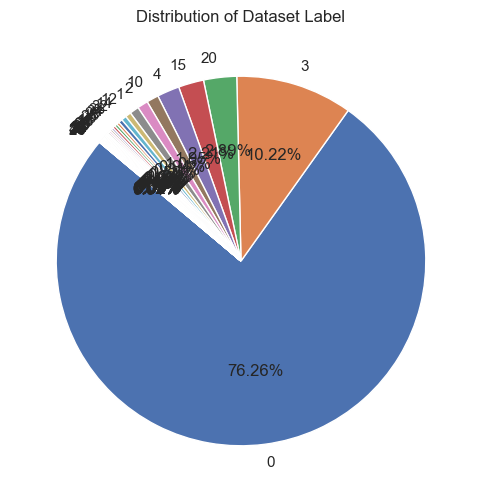

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize' : (6, 6)})

type_counts = df['val'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Dataset Label')
plt.show()

In [3]:
df_normal = df[df['val'] == 0]
df_vul = df[df['val'] != 0]
df_normal_sampled = df_normal.sample(int(df[df['val'] != 0].shape[0] / 2))

# Lấy idx  và set cho df_1_nor và df_1_vul
sampled_indices = df_normal_sampled.index
df_1_normal_sampled = df_1.loc[sampled_indices].copy()
df_1_vul = df_1[df_1['val'] != 0]

# Ghép nối lại thành df và df_1 mới
df = pd.concat([df_normal_sampled, df_vul]).reset_index(drop=True)
df_1 = pd.concat([df_1_normal_sampled, df_1_vul]).reset_index(drop=True)

In [4]:
df.shape, df_1.shape

((64678, 2), (64678, 2))

In [5]:
df_demo = df.sample(20000)
df_1_demo = df_1.loc[df_demo.index]
len(df_demo['val'].unique()), len(df_1_demo['val'].unique())

(41, 41)

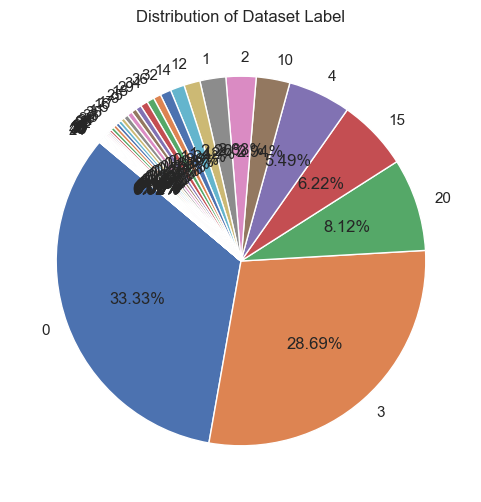

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize' : (6, 6)})

type_counts = df['val'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Dataset Label')
plt.show()

### Model

In [14]:
import gc
gc.collect()

vectors = np.stack(df_demo.iloc[:, 0].values)
vectors_attention = np.stack(df_1_demo.iloc[:, 0].values)
labels = df_demo.iloc[:, 1].values


X_train_gadget, X_test_gadget, y_train, y_test = train_test_split(vectors, labels,
                                    test_size=0.2, random_state = 42)

X_train_attention, X_test_attention = train_test_split(vectors_attention,
                                    test_size=0.2, random_state = 42)

unique_labels_train = np.unique(y_train) 
unique_labels_test = np.unique(y_test) 
classes = np.unique(y_train)
classes_test = np.unique(y_test)
print(classes)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


### BLSTM Feature Fusion

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Kích thước đầu vào
input_shape = (vectors.shape[1], vectors.shape[2])

def model(dropout_rate, learning_rate):
    # Global-feature learning model
    global_feature_model = tf.keras.Sequential(name="GlobalFeatureModel")
    global_feature_model.add(Bidirectional(LSTM(300, return_sequences=True), input_shape=input_shape))
    global_feature_model.add(Bidirectional(LSTM(300, return_sequences=True)))
    global_feature_model.add(Dropout(dropout_rate))
    global_feature_model.add(Dense(300, activation='tanh', name="global_feature_dense"))

    # Local-feature learning model
    local_feature_model = tf.keras.Sequential(name="LocalFeatureModel")
    local_feature_model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=input_shape))
    local_feature_model.add(Bidirectional(LSTM(200, return_sequences=True)))
    local_feature_model.add(Dropout(dropout_rate))
    local_feature_model.add(Dense(200, activation='tanh', name="local_feature_dense"))

    # Feature-fusion model
    feature_fusion_model = tf.keras.Sequential(name="FeatureFusionModel")
    concatenated_features = Concatenate(name="feature_concatenate")([local_feature_model.output, global_feature_model.output])
    blstm_layer = Bidirectional(LSTM(500), name="blstm_layer")(concatenated_features)
    dense_layer = Dense(500, activation='tanh', name="fusion_dense")(blstm_layer)
    dense_layer = Dense(41, activation='softmax', name="output")(dense_layer)
    feature_fusion_model = Model(inputs=[local_feature_model.input, global_feature_model.input], outputs=dense_layer)

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    feature_fusion_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return feature_fusion_model


In [9]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
dropout_rate = 0.5
num_epochs = 10
# Create the feature fusion model
feature_fusion_model = model(dropout_rate = dropout_rate, learning_rate= learning_rate)

# Print model summary
feature_fusion_model.summary()
plot_model(feature_fusion_model, show_shapes=True, show_layer_names=True)

### Trainning model 

In [14]:
from keras.callbacks import Callback, EarlyStopping
from time import time

input_data1 = X_train_gadget
input_data2 = X_train_attention
y_train_sample = y_train
earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=10)


callbacks_list = [earlystopping_1]
class_weight = compute_class_weight(class_weight='balanced', classes=unique_labels_train, y = classes)
class_weight_dict = dict(enumerate(class_weight))

start_time = time()
history = feature_fusion_model.fit(
    x=[input_data2,input_data1],
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=callbacks_list,
    validation_split=0.2, 
    class_weight=class_weight_dict,
)
end_time = time()

Epoch 1/10
200/200 [==============================] - 858s 4s/step - loss: 1.9640 - accuracy: 0.4258 - val_loss: 1.2855 - val_accuracy: 0.5706
Epoch 2/10
200/200 [==============================] - 787s 4s/step - loss: 1.1497 - accuracy: 0.6298 - val_loss: 1.0162 - val_accuracy: 0.6369
Epoch 3/10
200/200 [==============================] - 783s 4s/step - loss: 0.9082 - accuracy: 0.6970 - val_loss: 0.8812 - val_accuracy: 0.7044
Epoch 4/10
200/200 [==============================] - 822s 4s/step - loss: 0.7525 - accuracy: 0.7405 - val_loss: 0.7930 - val_accuracy: 0.7381
Epoch 5/10
200/200 [==============================] - 1140s 6s/step - loss: 0.6408 - accuracy: 0.7748 - val_loss: 0.6814 - val_accuracy: 0.7759
Epoch 6/10
200/200 [==============================] - 1072s 5s/step - loss: 0.5636 - accuracy: 0.8023 - val_loss: 0.6141 - val_accuracy: 0.7997
Epoch 7/10
200/200 [==============================] - 1063s 5s/step - loss: 0.5036 - accuracy: 0.8172 - val_loss: 0.5680 - val_accuracy: 0.8

### Predict

In [15]:
y_pred = feature_fusion_model.predict([X_test_attention, X_test_gadget])

125/125 [==============================] - 150s 1s/step


In [16]:
y_test_sample = y_test
y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test_sample, axis=1)

### Confusuin Matrix & Evaluate

In [17]:
cm = confusion_matrix(y_test_cm, y_pred_cm)
#Reshape confusion matrix
cm_reshaped = np.pad(cm, ((0, 41 - cm.shape[0]), (0, 41 - cm.shape[0])), mode='constant', constant_values=0)
cm_reshaped.shape

(41, 41)

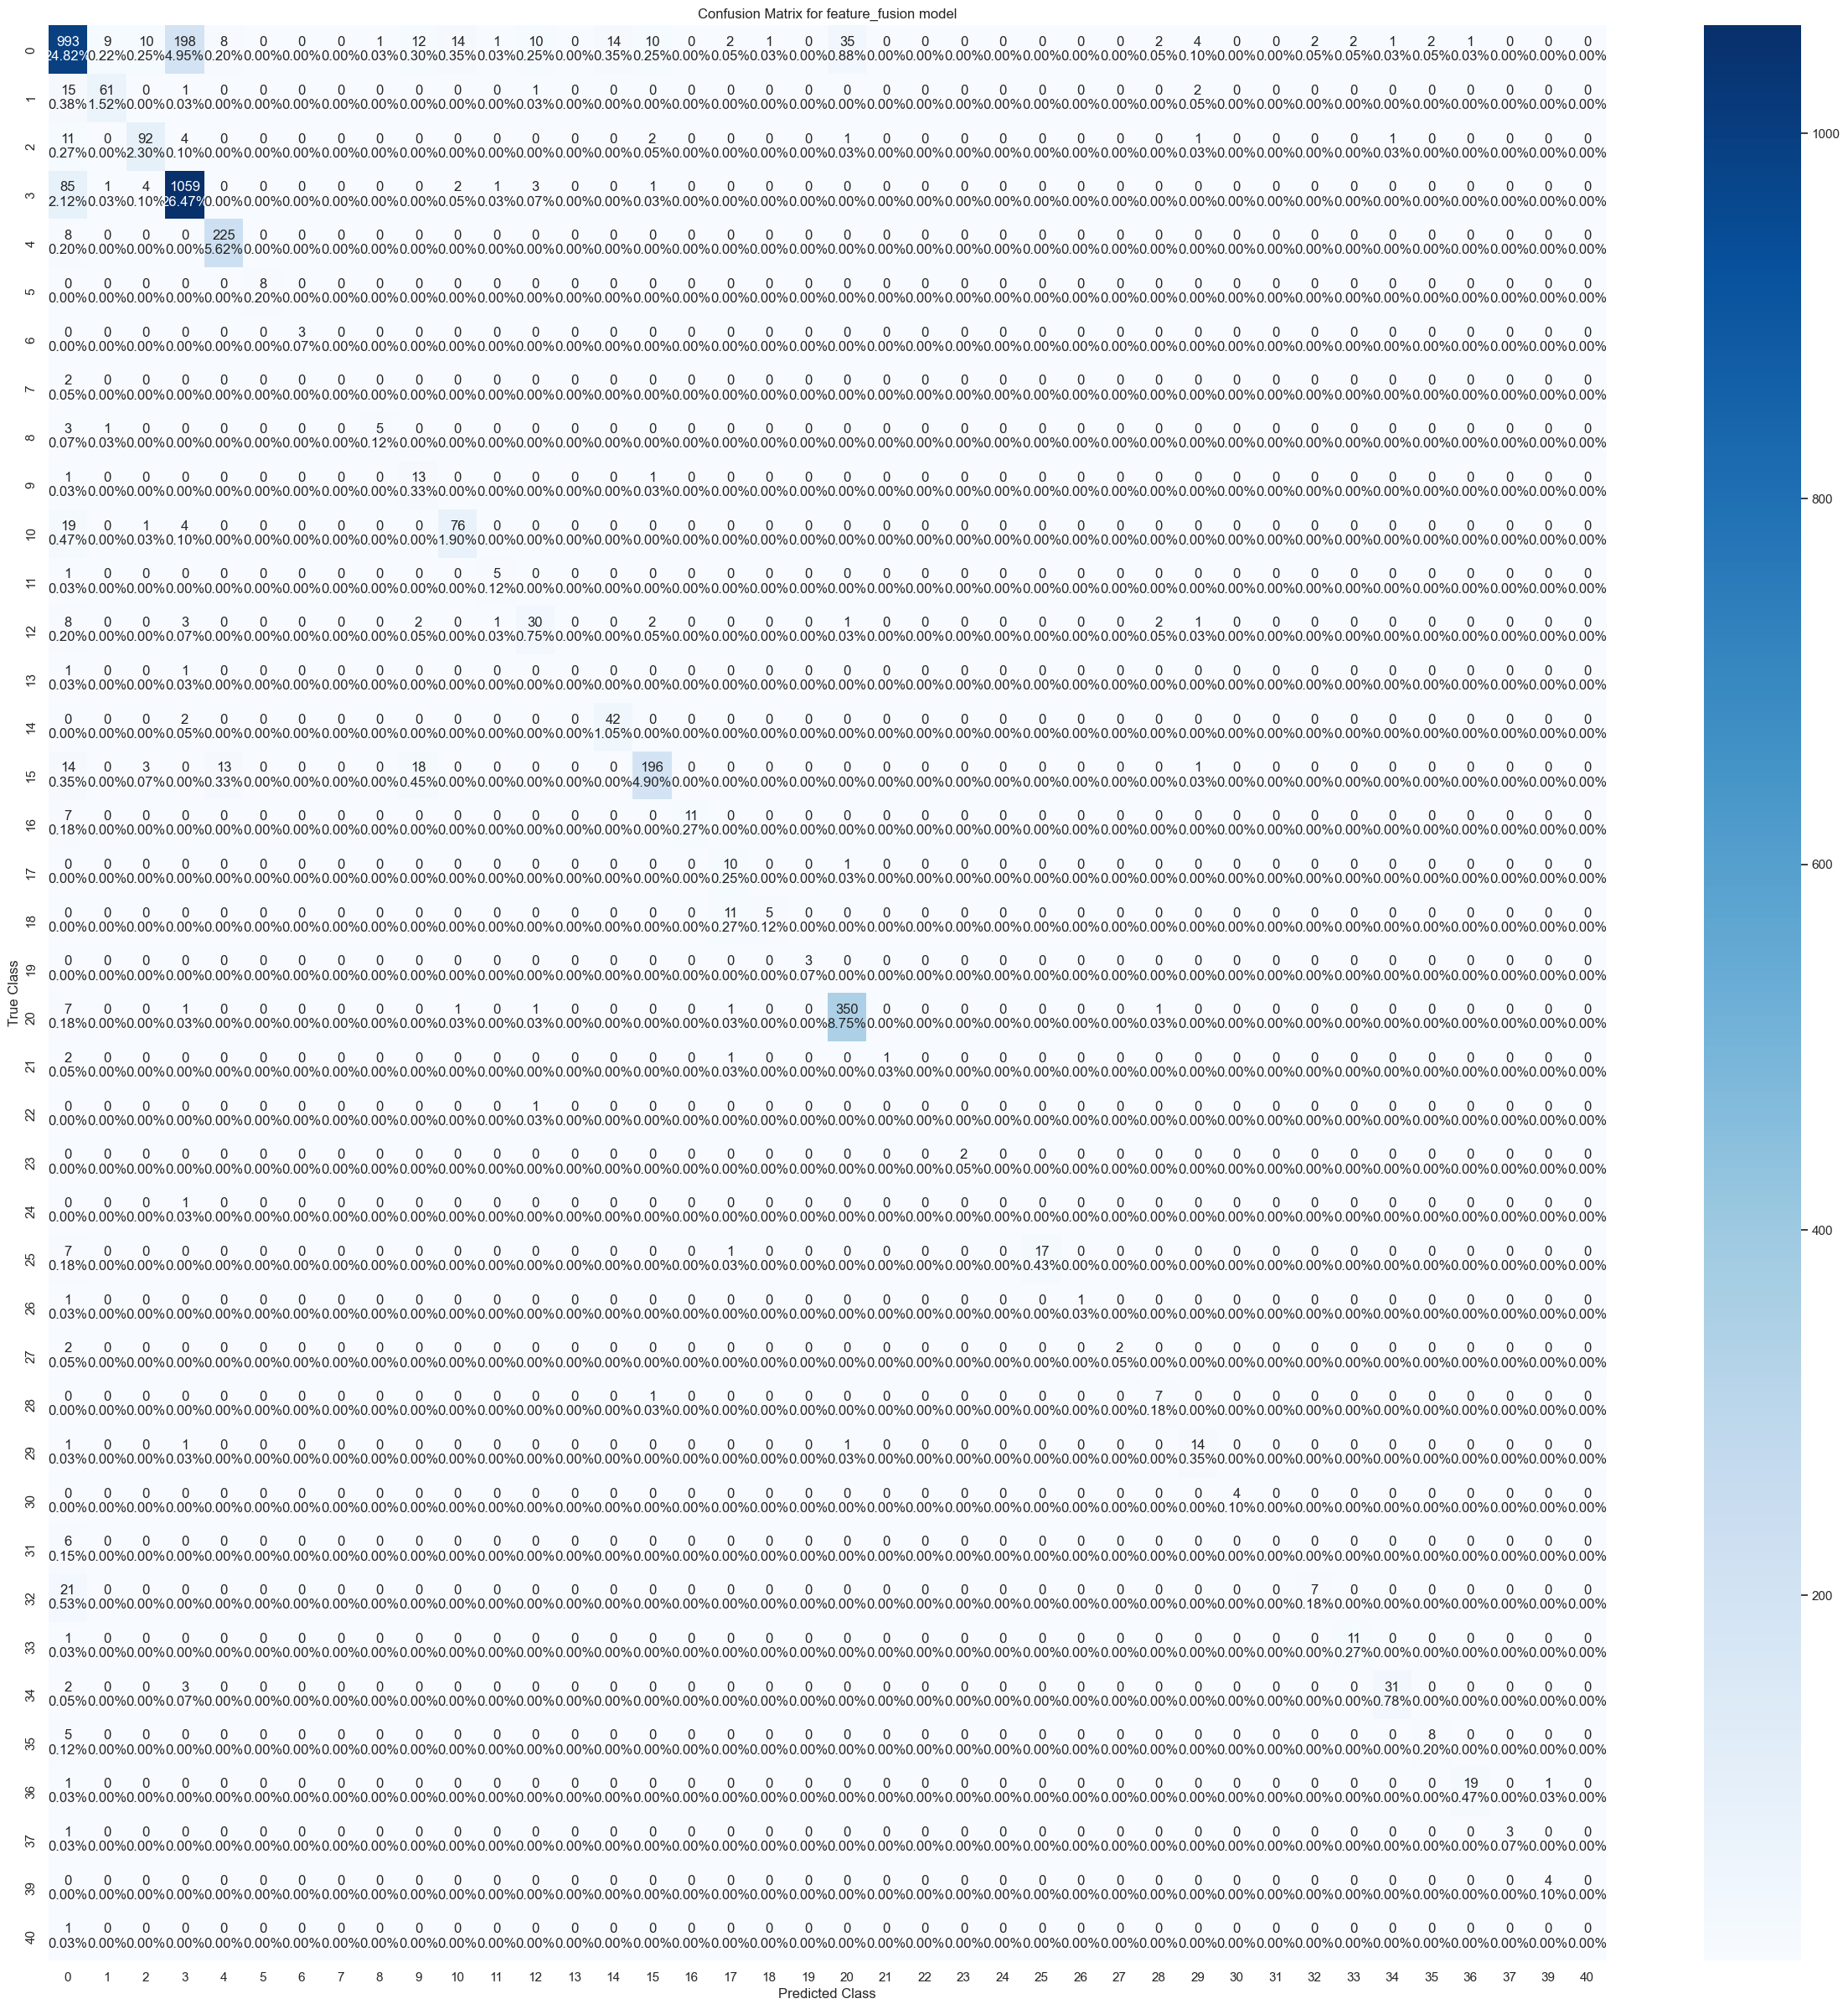

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(cm.shape)


label = unique_labels_test

plt.figure(figsize=(30,30))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.1)
plt.title('Confusion Matrix for'+ ' feature_fusion'+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [19]:
from sklearn.metrics import *
W_f1 = f1_score(y_test_cm, y_pred_cm, average = 'weighted')
M_f1 = f1_score(y_test_cm, y_pred_cm, average = None)
M_f1 = sum(M_f1) / len(M_f1)


TP = np.diag(cm) #Lấy đường chéo chính
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

# Loại bỏ giá trị NaN
FPR = FPR[~np.isnan(FNR)]
FNR = FNR[~np.isnan(FNR)]

# Tính giá trị trung bình
M_FPR = np.mean(FPR)
M_FNR = np.mean(FNR)    

class_samples = np.sum(y_test, axis=0)
weighted_FNR = np.zeros(cm_reshaped.shape[0])
weighted_FPR = np.zeros(cm_reshaped.shape[0])

for i in range(40):
    # Tính FNR và FPR cho từng nhãn
    TP = cm_reshaped[i, i]
    FP = np.sum(cm_reshaped[:, i]) - TP
    FN = np.sum(cm_reshaped[i, :]) - TP
    TN = np.sum(cm_reshaped) - (TP + FP + FN)

    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)

    # Tính trọng số FNR và FPR
    weighted_FNR[i] = FNR * class_samples[i]
    weighted_FPR[i] = FPR * class_samples[i]

# Tính tổng cộng trọng số và tính trung bình
total_samples = np.sum(class_samples)
W_FNR = np.sum(weighted_FNR) / total_samples
W_FPR = np.sum(weighted_FPR) / total_samples

print("W False Positive Rate (W_FPR):", W_FPR)
print("W False Negative Rate (W_FNR):", W_FNR)
print("Weight F1 Score:", W_f1)

print("M False Positive Rate (M_FPR):", M_FPR)
print("M False Negative Rate (M_FNR):", M_FNR)
print("Mean F1 Score:", M_f1)

accuracy = accuracy_score(y_test_cm, y_pred_cm)
print("Accuracy: ", accuracy)

training_time = end_time - start_time
print("Total Training Time: {:.2f} seconds".format(training_time))

W False Positive Rate (W_FPR): 0.05336050789492872
W False Negative Rate (W_FNR): 0.17125
Weight F1 Score: 0.8265173960443302
M False Positive Rate (M_FPR): 0.005596518953629474
M False Negative Rate (M_FNR): 0.3423178290726298
Mean F1 Score: 0.6573580077784744
Accuracy:  0.8295
Total Training Time: 9681.00 seconds


### Visualize 

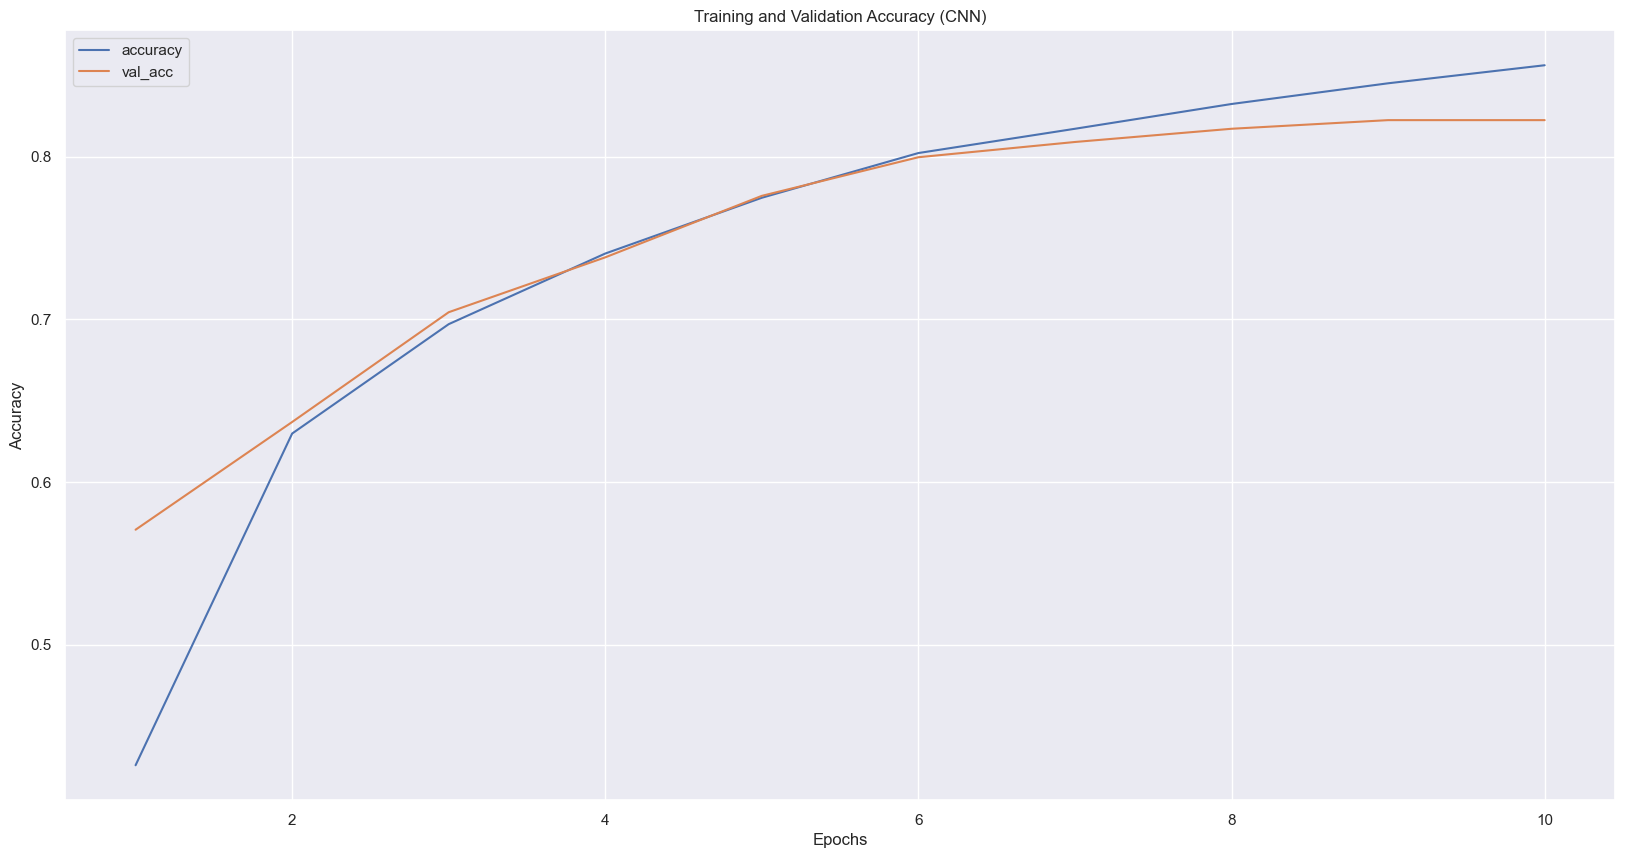

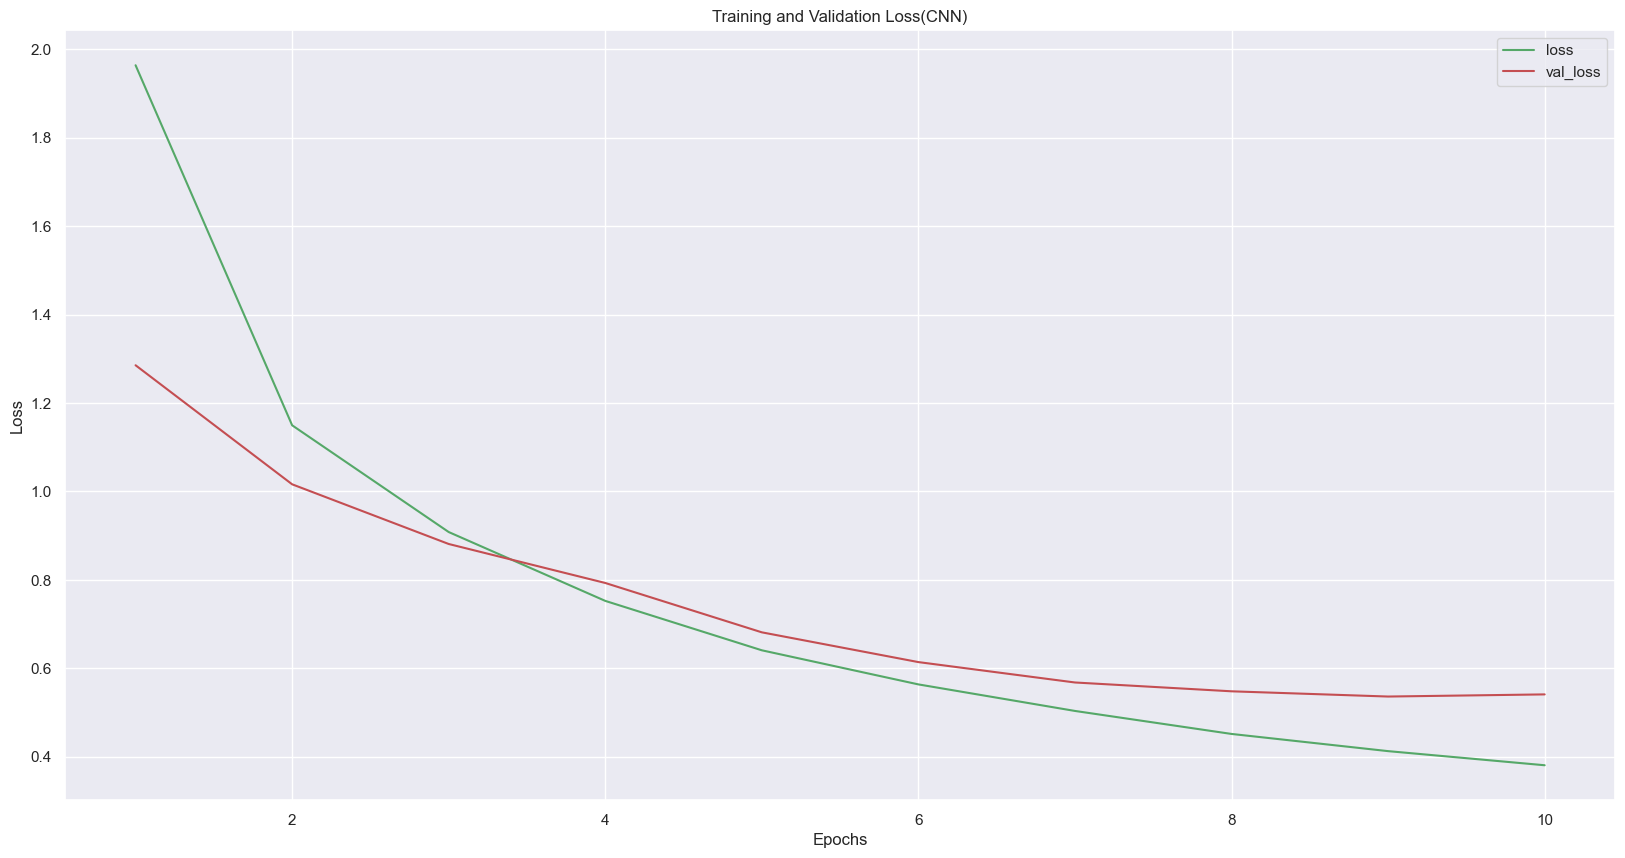

In [29]:
# check history of model
history = history.history
history.keys()

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(20, 10))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(20, 10))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

### Model Làm thêm

In [7]:
from tensorflow.keras.layers import SimpleRNN
def create_lightweight_rnn_model(dropout_rate, learning_rate):
    # Global-feature learning model
    global_feature_model = tf.keras.Sequential(name="GlobalFeatureModel")
    global_feature_model.add(Bidirectional(SimpleRNN(300, return_sequences=True), input_shape=(50, 50)))
    global_feature_model.add(Bidirectional(SimpleRNN(300, return_sequences=True)))
    global_feature_model.add(Dropout(dropout_rate))
    global_feature_model.add(Dense(300, activation='tanh'))

    # Local-feature learning model
    local_feature_model = tf.keras.Sequential(name="LocalFeatureModel")
    local_feature_model.add(Bidirectional(SimpleRNN(200, return_sequences=True), input_shape=(50, 50)))
    local_feature_model.add(Bidirectional(SimpleRNN(200, return_sequences=True)))
    local_feature_model.add(Dropout(dropout_rate))
    local_feature_model.add(Dense(200, activation='tanh'))

    # Feature-fusion model
    feature_fusion_model = tf.keras.Sequential(name="FeatureFusionModel")
    concatenated_features = Concatenate(name="feature_concatenate")([local_feature_model.output, global_feature_model.output])
    blstm_layer = Bidirectional(SimpleRNN(200, return_sequences=False), name="blstm_layer")(concatenated_features)
    dense_layer = Dense(500, activation='tanh')(blstm_layer)
    dense_layer = Dense(41, activation='softmax')(dense_layer)
    feature_fusion_model = tf.keras.Model(inputs=[local_feature_model.input, global_feature_model.input], outputs=dense_layer)

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    feature_fusion_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return feature_fusion_model

In [12]:
# Create the feature fusion model
feature_fusion_model_2 = create_lightweight_rnn_model(dropout_rate = dropout_rate, learning_rate= learning_rate)

# Print model summary
feature_fusion_model_2.summary()
plot_model(feature_fusion_model_2, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bidirectional_6_input (Inp  [(None, 50, 50)]             0         []                            
 utLayer)                                                                                         
                                                                                                  
 bidirectional_4_input (Inp  [(None, 50, 50)]             0         []                            
 utLayer)                                                                                         
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 50, 400)              100400    ['bidirectional_6_input[0][0]'
 onal)                                                              ]                         

In [22]:
class_weight = compute_class_weight(class_weight='balanced', classes=unique_labels_train, y = classes)
class_weight_dict = dict(enumerate(class_weight))
start_time = time()
history_2 = feature_fusion_model_2.fit(
    x=[input_data2,input_data1],
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    callbacks=callbacks_list,
    validation_split=0.2,
    class_weight=class_weight_dict, 
)
end_time = time()

Epoch 1/10
200/200 [==============================] - 201s 1s/step - loss: 0.9261 - accuracy: 0.7077 - val_loss: 0.9320 - val_accuracy: 0.7147
Epoch 2/10
200/200 [==============================] - 189s 945ms/step - loss: 0.8458 - accuracy: 0.7256 - val_loss: 0.8660 - val_accuracy: 0.7297
Epoch 3/10
200/200 [==============================] - 185s 924ms/step - loss: 0.7870 - accuracy: 0.7398 - val_loss: 0.8179 - val_accuracy: 0.7425
Epoch 4/10
200/200 [==============================] - 199s 995ms/step - loss: 0.7402 - accuracy: 0.7520 - val_loss: 0.7853 - val_accuracy: 0.7519
Epoch 5/10
200/200 [==============================] - 281s 1s/step - loss: 0.7018 - accuracy: 0.7686 - val_loss: 0.8079 - val_accuracy: 0.7362
Epoch 6/10
200/200 [==============================] - 182s 909ms/step - loss: 0.6752 - accuracy: 0.7721 - val_loss: 0.7522 - val_accuracy: 0.7628
Epoch 7/10
200/200 [==============================] - 193s 964ms/step - loss: 0.6448 - accuracy: 0.7800 - val_loss: 0.7314 - val_a

In [23]:
y_pred_light_RNN = feature_fusion_model_2.predict([X_test_attention,X_test_gadget])
y_test_sample = y_test

y_pred_Light_RNN_cm  = np.argmax(y_pred_light_RNN, axis=1)

125/125 [==============================] - 75s 579ms/step


In [26]:
cm_light_RNN = confusion_matrix(y_test_cm, y_pred_Light_RNN_cm)
#Reshape confusion matrix
cm_reshaped_2 = np.pad(cm_light_RNN, ((0, 41 - cm_light_RNN.shape[0]), (0, 41 - cm_light_RNN.shape[0])), mode='constant', constant_values=0)
cm_reshaped_2.shape

(41, 41)

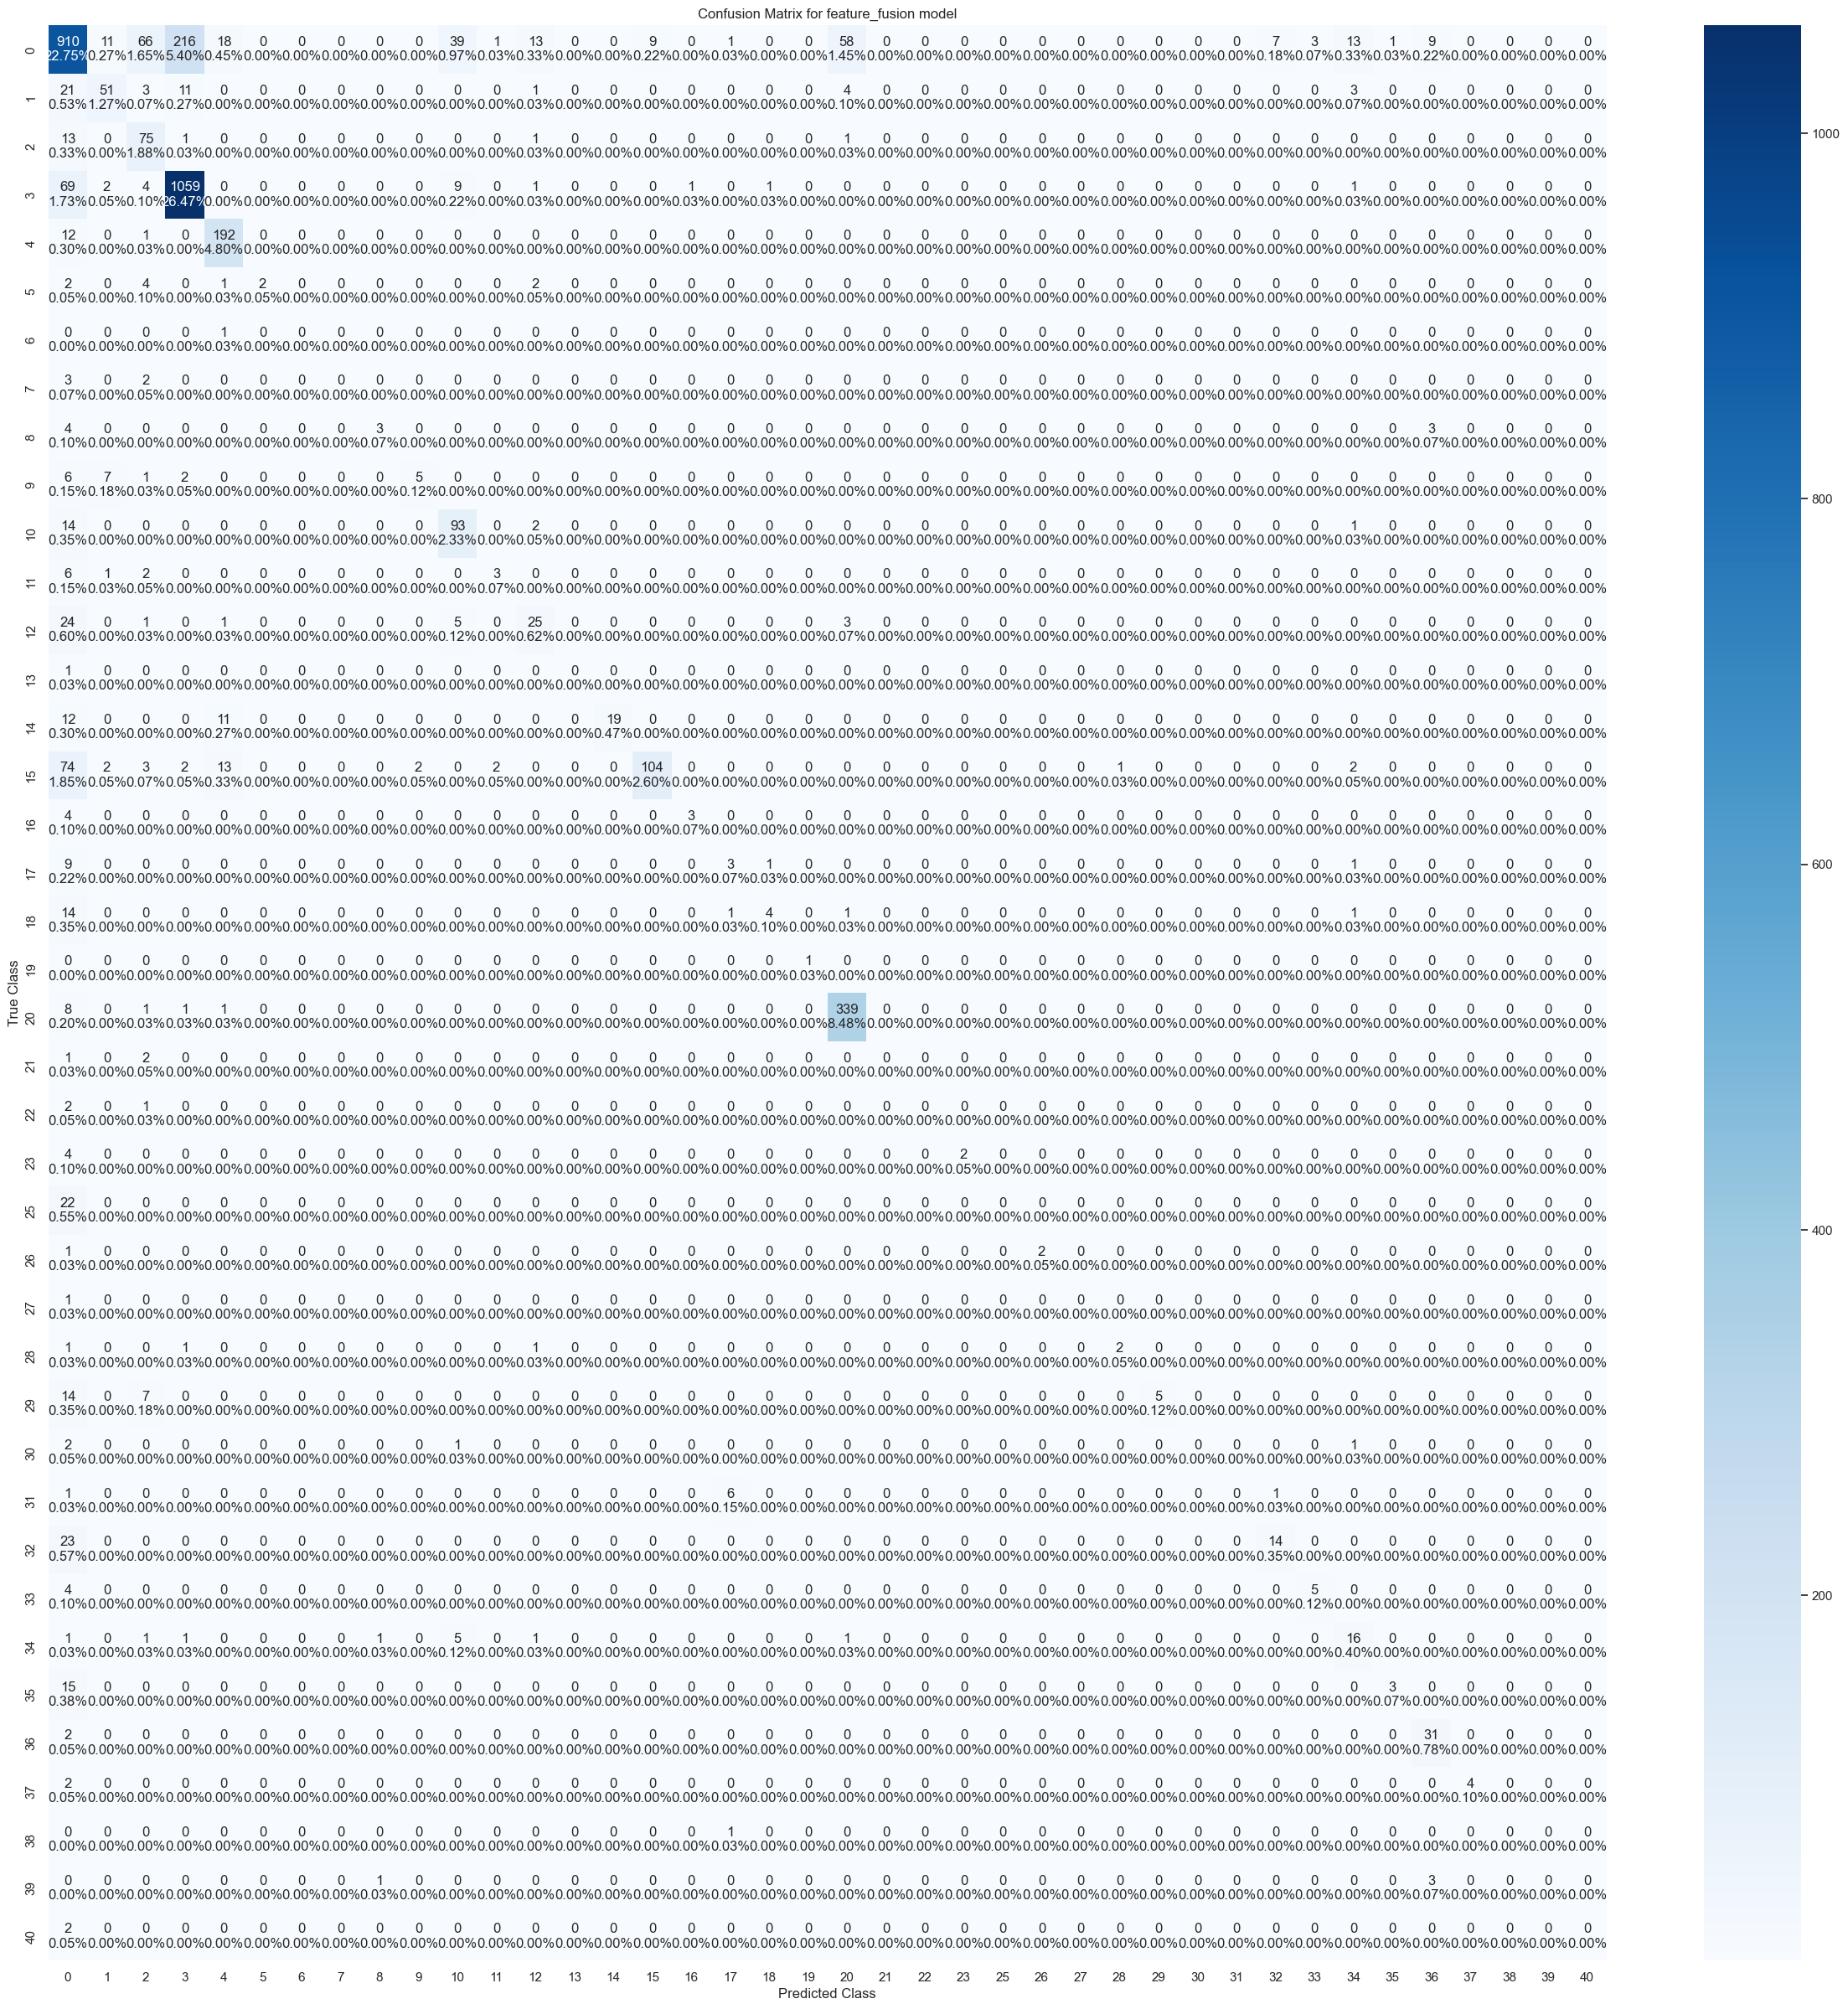

In [27]:
group_counts = ["{0:0.0f}".format(value) for value in cm_light_RNN.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm_light_RNN.flatten()/np.sum(cm_light_RNN)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(cm_light_RNN.shape)


label = unique_labels_test

plt.figure(figsize=(30,30))
sns.heatmap(cm_light_RNN, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.1)
plt.title('Confusion Matrix for'+ ' feature_fusion'+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [28]:
from sklearn.metrics import *
W_f1 = f1_score(y_test_cm, y_pred_Light_RNN_cm, average = 'weighted')
M_f1 = f1_score(y_test_cm, y_pred_Light_RNN_cm, average = None)
M_f1 = sum(M_f1) / len(M_f1)


TP = np.diag(cm_light_RNN) #Lấy đường chéo chính
FP = np.sum(cm_light_RNN, axis=0) - TP
FN = np.sum(cm_light_RNN, axis=1) - TP
TN = np.sum(cm_light_RNN) - (TP + FP + FN)

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

# Loại bỏ giá trị NaN
FPR = FPR[~np.isnan(FNR)]
FNR = FNR[~np.isnan(FNR)]

# Tính giá trị trung bình
M_FPR = np.mean(FPR)
M_FNR = np.mean(FNR)    

class_samples = np.sum(y_test, axis=0)
weighted_FNR = np.zeros(cm_reshaped_2.shape[0])
weighted_FPR = np.zeros(cm_reshaped_2.shape[0])

for i in range(40):
    # Tính FNR và FPR cho từng nhãn
    TP = cm_reshaped_2[i, i]
    FP = np.sum(cm_reshaped_2[:, i]) - TP
    FN = np.sum(cm_reshaped_2[i, :]) - TP
    TN = np.sum(cm_reshaped_2) - (TP + FP + FN)

    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)

    # Tính trọng số FNR và FPR
    weighted_FNR[i] = FNR * class_samples[i]
    weighted_FPR[i] = FPR * class_samples[i]

# Tính tổng cộng trọng số và tính trung bình
total_samples = np.sum(class_samples)
W_FNR = np.sum(weighted_FNR) / total_samples
W_FPR = np.sum(weighted_FPR) / total_samples

print("W False Positive Rate (W_FPR):", W_FPR)
print("W False Negative Rate (W_FNR):", W_FNR)
print("Weight F1 Score:", W_f1)

print("M False Positive Rate (M_FPR):", M_FPR)
print("M False Negative Rate (M_FNR):", M_FNR)
print("Mean F1 Score:", M_f1)

accuracy = accuracy_score(y_test_cm, y_pred_Light_RNN_cm)
print("Accuracy: ", accuracy)

training_time = end_time - start_time
print("Total Training Time: {:.2f} seconds".format(training_time))

W False Positive Rate (W_FPR): 0.07886146377422008
W False Negative Rate (W_FNR): 0.254161697011697
Weight F1 Score: 0.7290660976805916
M False Positive Rate (M_FPR): 0.008379018822660698
M False Negative Rate (M_FNR): 0.6304832065472812
Mean F1 Score: 0.3984950224793253
Accuracy:  0.74375
Total Training Time: 2046.56 seconds


### Visualize

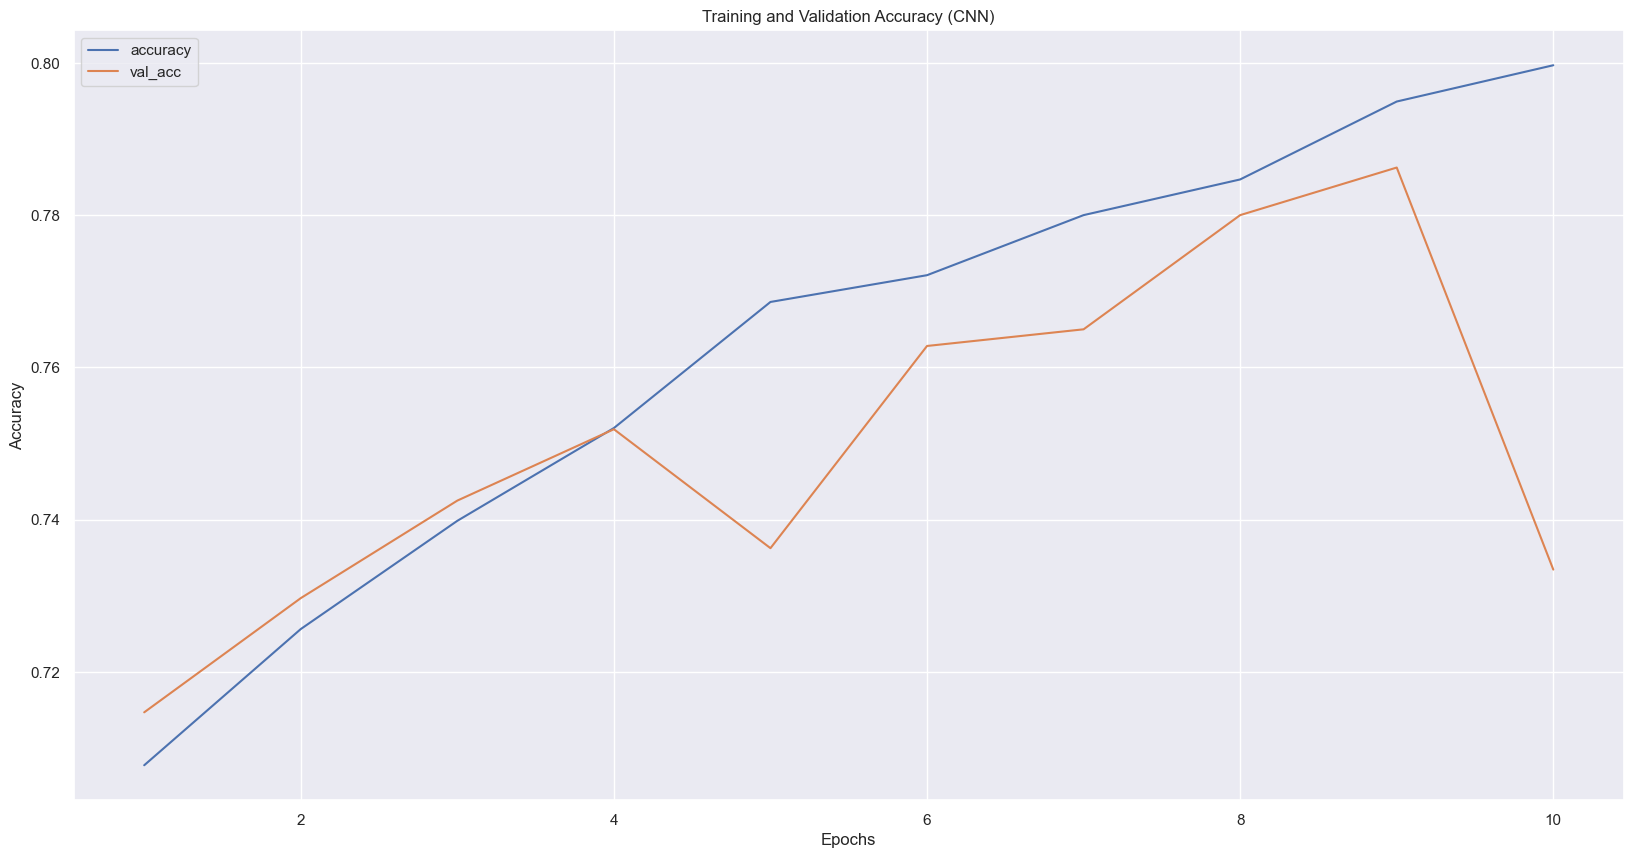

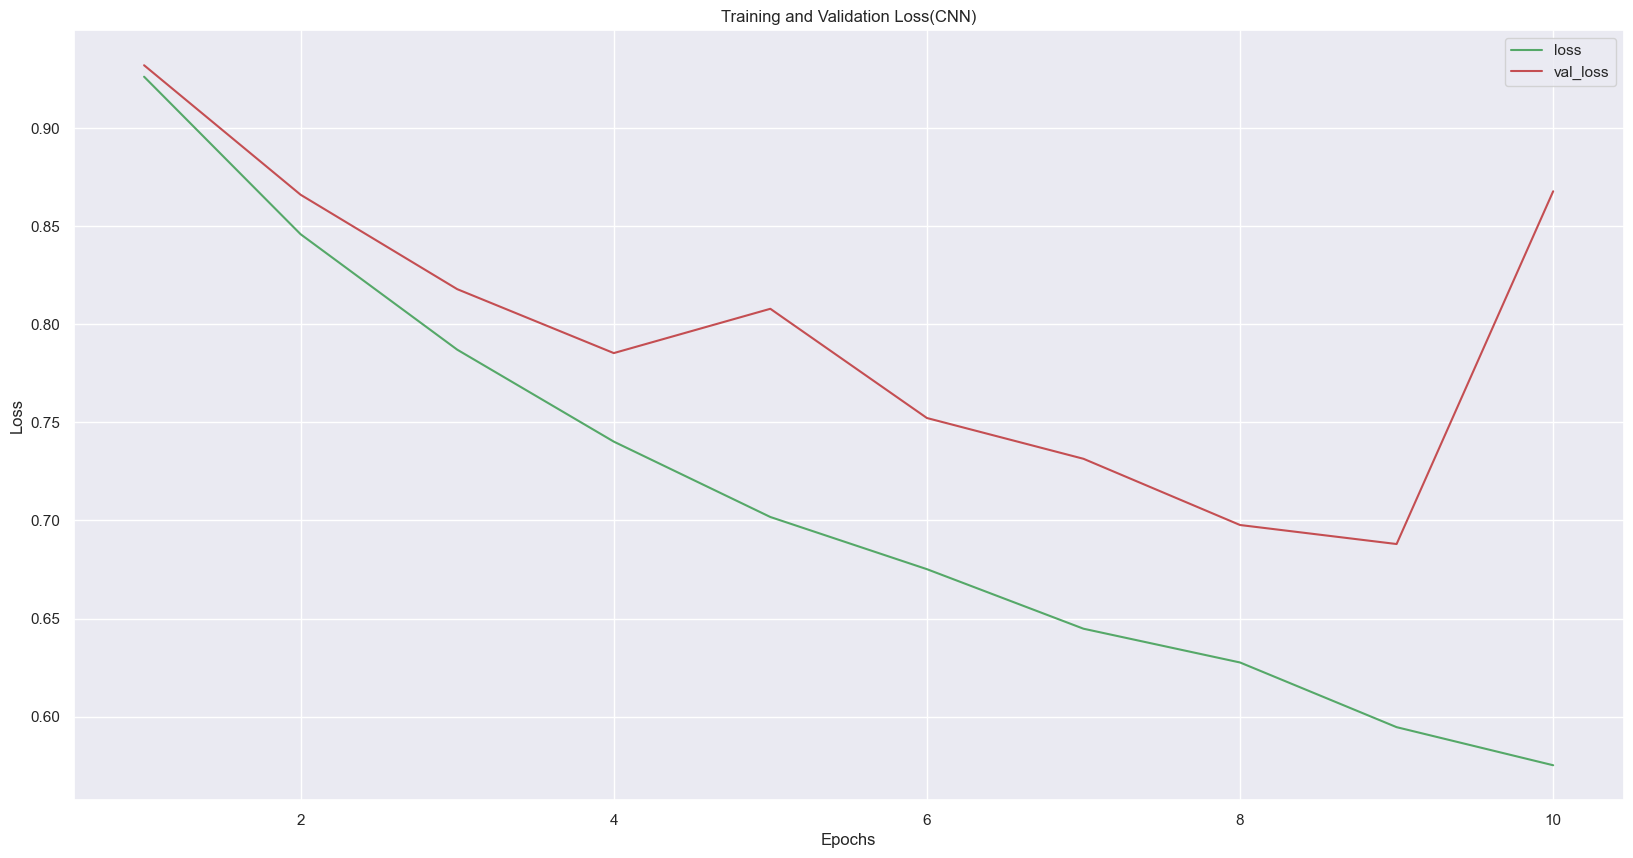

In [29]:
# check history of model
history = history_2.history
history.keys()

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(20, 10))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(20, 10))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

### Save model

In [31]:
# feature_fusion_model.save("feature_fusion_model.h5")
# print("Saved model to disk")

feature_fusion_model_2.save("feature_fusion_model_2.h5")
print("Saved model to disk")

Saved model to disk
